In [2]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

# Chapter 5
* **multivariate regression**: using more than one predictor variable to model an outcome. useful b/c
  * control for confounds. **confound**: variable that might be correlated w/ variable of interest, e.g. nr of waffle houses and divorce rate. can hide important variables or can create false importance. **simpson's paradox**: reverse direction between predictor and outcome due to confound.
  * multiple causation. something might be caused by more than one thing
  * interactions. car needs fuel and spark to start, only one does not have any effect.
* this chapter: confounds and multiple causation
* also danger: multicollinerarity
* **rethinking: causal inference:** extremely important, but no unified approach to determine causal effect, neither in sciences nor in statistic. furthermore, 'cause' loses clear meaning in complex systems in which everything seems to cause everything (and be caused by it). consensus: inference of causality always rests upon unverifiable assumptions. so no matter the analysis, there will always be possible criticism about whether there really is causality. however: even despite that useful work can be done

## 5.1. Spurious association
* impact of median marriage age of marriage on divorce rate

In [3]:
# Code 5.1
d = pd.read_csv('./data/WaffleDivorce.csv', sep=';')

In [4]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

with pm.Model() as m5_1:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bA = pm.Normal('bA', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1423.11draws/s]


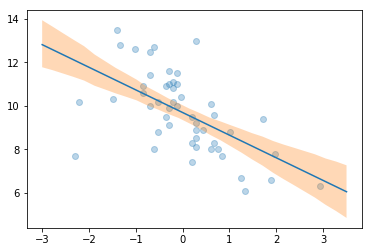

In [6]:
# Code 5.2
MAM_seq = np.linspace(-3, 3.5, 30)
mu = np.reshape(trace_m5_1['a'], (-1, 1)) + np.reshape(trace_m5_1['bA'], (-1, 1)) * np.reshape(MAM_seq, (1, -1))
mu_PI = pm.hpd(mu, alpha=.11)
mu_mean = mu.mean(axis=0)

plt.scatter(x=d.MedianAgeMarriage_s, y=d.Divorce, alpha=.3);
plt.plot(MAM_seq, mu_mean);
plt.fill_between(x=MAM_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=.3);

In [7]:
varnames = ['bA', 'a', 'sigma']

In [8]:
pm.summary(trace_m5_1, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bA,-1.040807,0.211278,0.004575,-1.445364,-0.621547,2367.934028,0.999663
a,9.693218,0.215262,0.004073,9.253971,10.108300,2885.887334,1.000652
sigma,1.512359,0.149266,0.003296,1.246275,1.833029,2374.310462,0.999537


In [9]:
# Code 5.3
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

with pm.Model() as m5_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bR = pm.Normal('bR', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1396.23draws/s]


In [10]:
pm.summary(trace_m5_2, varnames=['sigma', 'bR', 'a'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,1.750981,0.175778,0.003598,1.429028,2.125569,2449.291754,0.999947
bR,0.640814,0.249541,0.005164,0.181837,1.189155,2579.664998,1.000613
a,9.682397,0.259197,0.005217,9.192778,10.214560,2367.360753,1.001006


* median age of marriage has stronger association with divorce rate than the one that marriage rate has
* however, does not answer which one is better predictor. they could have independent information, or be redundant or could eliminate each other
* want to build multivariate model to determine partial value added by each predictor. in particular, question is **what is predictive value of variable once i know value of all variables?**
* **rethinking: "control" is outside of control** this question often talked about as 'statistical control'. estimating effect of one variable while controlling for effect of another. however: sloppy language. implies causality ('effect') and dissasociation of predictors ('control'), neither of which is a fact in the model, even though it might be made by analyst. power of statistical methods does not extend to this, must be careful not to make this wrong impression, otherwise interpretation of results will also be based on wrong understanding

### 5.1.1. multivariate notation
* straightforward extension of univariate models, just add multiple parameters into formula for mean and add priors for their parameters for all of them
* what does $\mu_i = \alpha + \beta_R R_i + \beta_A A_i$ mean? expected outcome for any state is sum of three independent terms. can be read as "divorce rate can function of marriage rate ($R_i$) OR median marriage age ($A_i$)". "OR" implies that both factors are independent
* **overthinking: design matrix** **design matrix** = matrix of features with additional column of '1's in the beginning. used in equation $m = Xb$, where $m$ = predicted means (one for each row of data), $X$ = design matrix w/ one row per row of data, one col per predictor and extra '1' col and $b$ = col vector of parameters

### 5.1.2. fitting the model
* exactly as expected

In [11]:
# Code 5.4
with pm.Model() as m5_3:
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    a = pm.Normal('a', mu=10, sd=10)
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s + bA * d.MedianAgeMarriage_s)
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bA, bR]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 793.72draws/s] 


In [12]:
pm.summary(trace_m5_3, varnames=['bR', 'bA', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bR,-0.131731,0.297333,0.007244,-0.720416,0.451590,1484.359752,0.999502
bA,-1.132291,0.298893,0.008067,-1.715941,-0.549006,1371.506221,0.999741
a,9.681971,0.218629,0.005025,9.257006,10.112979,1619.715294,0.999537
sigma,1.522077,0.168912,0.004451,1.220048,1.845505,1521.465745,0.999566


In [13]:
params = ['sigma', 'bA', 'bR', 'a']

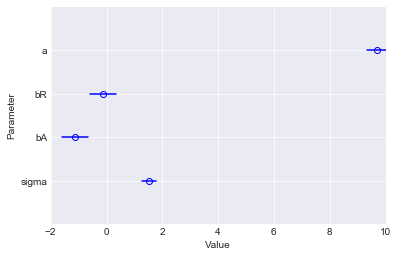

In [14]:
# Code 5.5
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()
# ax.plot([1, 2, 3], [1, 2, 3])
ax.set(xlabel='Value', ylabel='Parameter')
ax.set_xlim(-2, 10)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(params)
for ix, pname in enumerate(params):
    # 'mwe' = marker edge weight
    # necessary to draw empty circles, defaults to 0, meaning circles will be invisible if not filled
    ax.plot(trace_m5_3[pname].mean(), ix+1, 'ob', fillstyle='none', mew=1)
    hpd_boundaries = pm.hpd(trace_m5_3[pname], alpha=.11)
    ax.plot(hpd_boundaries, [ix+1, ix+1], '-b')

* interpretation: "once we know median age of marriage, learning about marriage rate does not give us much additional information"
* **why is this the interpretation? are these factors not independent? see if this is answered in remainder of section, discuss**

### 5.1.3. plotting multivariate posteriors
* tons of books and other literature on specialized plots. but: none suitable to all jobs, typically don't generalize beyond linear regression.
* instead: understand approaches to ask model whatever interesting questions we come up with
* plot categories:
  * predictor residual plots
  * counterfactual plots. implied predictions for imaginary experiments
  * posterior prediction plots. model-based predictions against raw data or other types of prediction error
  
#### 5.1.3.1. Predictor residual plots
* idea: predict values of one predictor using all other predictors. calculate residuals of that prediction, i.e. how much of target predictor is not determined by combination of other predictors? plot these. 
* also calculate and plot dependent variable of overall problem (here: divorce rate) against these residuals. can even fit linear model between residuals and dependent variable. 
* interpretation: what's the association between residuals and dependent variable? positive residuals: predictor is higher than expected given other predictors. negative residuals: predictor is lower than expected given other residuals. is there a connection between this quantity and the dependent variable? e.g. is there a relation between predictor 'median age of marriage' being unexpectedly high/low and dependent variable 'divorce rate'?
* **still shaky on exact interpretation, discuss this**
* let's go through the code + examples, maybe can help to make things clearer

In [15]:
# Code 5.6
with pm.Model() as m5_4:
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    b = pm.Normal('b', mu=0, sd=1)
    a = pm.Normal('a', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage_s = pm.Normal('Marriage_s', mu=mu, sd=sigma, observed=d.Marriage_s)
    
    trace_m5_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 932.17draws/s] 


In [16]:
# Code 5.7
trace_m5_4_pd = pm.trace_to_dataframe(trace_m5_4)
trace_m5_4_pd.head()

,b,a,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.763839,-0.020586,0.717056,0.442522,0.503942,0.135421,1.056723,-0.478780,0.196841,-0.970140,...,0.258261,0.503942,0.503942,1.670923,-0.540200,-0.233099,0.074001,0.626782,-0.171679,1.118143
1,-0.763839,-0.020586,0.717056,0.442522,0.503942,0.135421,1.056723,-0.478780,0.196841,-0.970140,...,0.258261,0.503942,0.503942,1.670923,-0.540200,-0.233099,0.074001,0.626782,-0.171679,1.118143
2,-0.767930,-0.190204,0.716465,0.275383,0.337132,-0.033362,0.892874,-0.650852,0.028387,-1.144844,...,0.090136,0.337132,0.337132,1.510364,-0.712601,-0.403856,-0.095111,0.460630,-0.342107,0.954623
3,-0.744006,0.163262,0.618695,0.614345,0.674170,0.315218,1.212598,-0.283035,0.375044,-0.761638,...,0.434869,0.674170,0.674170,1.810852,-0.342860,-0.043734,0.255393,0.793821,0.016092,1.272424
4,-0.779605,-0.169757,0.731930,0.302909,0.365597,-0.010530,0.929788,-0.637408,0.052158,-1.138911,...,0.114846,0.365597,0.365597,1.556666,-0.700096,-0.386657,-0.073218,0.490973,-0.323969,0.992475


In [17]:
# each state corresponds to one of the 'mu_x' columns in the trace dataframe. for each sample of (a, b) a value of mu for
# each state (0 through 49) was calculated
# thus: MAP mu for state 0 = mean of mu_0 column, I think? **verify this**
mu = trace_m5_4_pd.filter(axis=1, like='mu__').mean()

In [18]:
# need '.values' to use ndarrays so that meaningless indices are ignored
m_resid = d.Marriage_s.values - mu.values

[Text(0,0.5,'Marriage_s'), Text(0.5,0,'MedianAgeMarriage_s')]

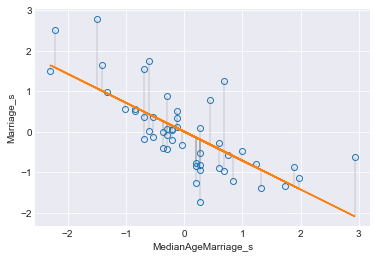

In [19]:
# Code 5.8
fig, ax = plt.subplots()
ax.plot('MedianAgeMarriage_s', 'Marriage_s', 'o', fillstyle='none', mew=1, data=d);
ax.plot(d.MedianAgeMarriage_s, mu)
ax.vlines(x=d.MedianAgeMarriage_s, ymin=mu, ymax=d.Marriage_s, alpha=0.1)
ax.set(xlabel='MedianAgeMarriage_s', ylabel='Marriage_s')

* grey lines = residuals
* side note: **this matches book plot, thus using mu_X samples to get map for datum X seems valid approach. neato**
* "notice that residuals are variation in marriage rate that is left over, after taking out the purely linear relationship between the two variables." **what does this mean exactly?**
* book includes more plots which plot residuals vs divorce rates. **how do i interpret those?**
  * book says: "you can think of this plot as displaying the linear relationship between divorce and marriage rates having statistically 'controlled' for median age of marriage" **still unclear what 'controlled for' _really, really_ means**
  * plots show that after 'controlling' for m_age, m_rate does not give a lot of extra info on d_rate. however, m_age *does* give a lot of extra info on d_rate after 'controlling' for d_age. thus: m_age higher predictive power, extra information not contained in m_rate?
  * book finds the following: assume that in multivariate model (m_rate, m_age) -> d_rate we find cofficients 0.1 for m_rate and 0.8 for m_age. Then if we fit a lin model like (m_rate_residuals_after_controlling_for_m_age) -> d_rate we'll find coefficient 0.1, and mutatis mutandis we'll find 0.8 for m_age_residuals_after_controlling_for_m_rate
  * learning the book takes from this: **coefficent in regression model is association between predictor and dependent variable when already knowing about all other predictors**
    * lin models do this assuming specific additivity between predictors. other models can assume other relationships between predictors. basic logic of statistical control stays the same, but residual plots do not work in the same way
    
#### 5.1.3.2. Counterfactual plots
* plot model predictions. 'counterfactual' b/c can also do this for predictor values that have not been observed or are straight up impossible
* simplest use: see how predictions behave when changing one predictor and keeping all others fixed
* helps understanding implications of model
* first example:

In [96]:
# Code 5.9

# prepare new counterfactual data

# note: isn't MedianAgeMarriage_s.mean() guaranteed to be 0 by definition of a standardized variable?
A_avg = d.MedianAgeMarriage_s.mean()
R_seq = np.linspace(start=-3, stop=3, num=30)
pred_data = pd.DataFrame(
    data={
        'Marriage_s': R_seq, 
        'MedianAgeMarriage_s': A_avg
    }
)

# compute counterfactual mean divorce (mu)

# mu dimensions: n_mcmc_samples x n_data_points
mu = trace_m5_3['a'].reshape(-1, 1) + trace_m5_3['bR'].reshape(-1, 1) @ pred_data.Marriage_s.values.reshape(1, -1) + trace_m5_3['bA'].reshape(-1, 1) @ pred_data.MedianAgeMarriage_s.values.reshape(1, -1)
mu_mean = mu.mean(axis=0)
mu_PI = pm.hpd(mu, alpha=0.11)

# R_sim dimensions same as mu dimensions. One col per mcmc sample, one row per input datum
R_sim = np.random.normal(loc=mu, scale=trace_m5_3['sigma'].reshape(-1, 1))
R_PI = pm.hpd(R_sim, alpha=0.11)

fig, ax = plt.subplots()
ax.set(xlabel='Marriage.s', ylabel='Divorce', title='MedianAgeMarriage.s=0');
ax.plot(R_seq, mu_mean);
# ax.plot(d.Marriage_s, d.Divorce, 'o', alpha=0.9, fillstyle='none', mew=1);
ax.fill_between(R_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=0.7);
ax.fill_between(R_seq, y1=R_PI[:, 0], y2=R_PI[:, 1], alpha=0.3);

AttributeError: 'DataFrame' object has no attribute 'MedianAgeMarriage_s'

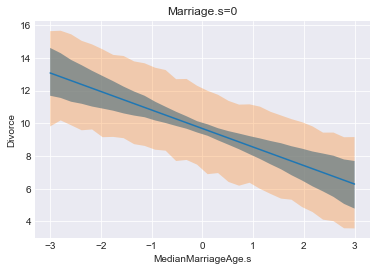

In [21]:
# Code 5.10

# prepare new counterfactual data

# note: isn't MedianAgeMarriage_s.mean() guaranteed to be 0 by definition of a standardized variable?
R_avg = d.Marriage_s.mean()
A_seq = np.linspace(start=-3, stop=3, num=30)
pred_data2 = pd.DataFrame(
    data={
        'Marriage_s': R_avg, 
        'MedianAgeMarriage_s': A_seq
    }
)

# compute counterfactual mean divorce (mu)

# mu dimensions: n_mcmc_samples x n_data_points
mu = trace_m5_3['a'].reshape(-1, 1) + trace_m5_3['bR'].reshape(-1, 1) @ pred_data2.Marriage_s.values.reshape(1, -1) + trace_m5_3['bA'].reshape(-1, 1) @ pred_data2.MedianAgeMarriage_s.values.reshape(1, -1)
mu_mean = mu.mean(axis=0)
mu_PI = pm.hpd(mu, alpha=0.11)

# R_sim dimensions same as mu dimensions. One col per mcmc sample, one row per input datum
R_sim = np.random.normal(loc=mu, scale=trace_m5_3['sigma'].reshape(-1, 1))
R_PI = pm.hpd(R_sim, alpha=0.11)

fig, ax = plt.subplots()
ax.set(xlabel='MedianMarriageAge.s', ylabel='Divorce', title='Marriage.s=0');
ax.plot(A_seq, mu_mean);
# ax.plot(d.Marriage_s, d.Divorce, 'o', alpha=0.9, fillstyle='none', mew=1);
ax.fill_between(A_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=0.7);
ax.fill_between(A_seq, y1=R_PI[:, 0], y2=R_PI[:, 1], alpha=0.3);

* note: above 2 plots have different scales on y-axis. makes them harder to compare
* **don't display data b/c they're counterfactual**
* display data on percentile interval scale, not residual scale
* thus: direct depiction of how prediction varies w/ change in one predictor
* **watch out: these isolated effects probably only possible in small world of model**
* in actual, real world, predictors most likely won't vary indepdenently, e.g. if median age of marriage increase then marriage rate will like decrease
* these plots always help in understanding the model, but might also mislead by displaying behavior for unrealistic combinations of predictors. we might not be able to manipulate real world enough to create such predictor combinations

#### 5.1.3.3. Posterior prediction plots
* Important to not just understand estimates, but also fit to data
* two main use cases:
  ** did model fit correctly? can catch software and users errors like this
  ** how does model fail? "all models are useful fictions, so they always fail in some ways". model could fit well but still not be fit for purpose. also, model might be okay overall, but can inspect where it's working better or worse. can also give ideas for model improvement
* let's make predictions averaging over posterior

In [22]:
# Code 5.11

# mu = samples of posterior for mu variable given by linear model for predictor combinations of original dataset
# can use 'mu' values from trace_m5_3 which correspond to post. samples for original predictor values 0 thru 49
trace_m5_3_pd = pm.trace_to_dataframe(trace_m5_3)

# shape: n_mcmc_samples x n_original_data_points
mu = trace_m5_3_pd.filter(like='mu__', axis=1)
# shape: (n_original_data_points, )
# '.values' so both mu_X variables have same datatype of ndarray
mu_mean = mu.mean().values
# shape: (n_original_data_points, 2)
mu_PI = pm.hpd(mu.values, alpha=0.11)

# shape: n_mcmc_samples x n_original_data_points
divorce_sim = np.random.normal(
    loc=mu.values, 
    scale=trace_m5_3_pd.sigma.values.reshape(-1, 1) # add 1 axis to make broadcastable
)
divorce_PI = pm.hpd(divorce_sim, alpha=0.11)

* **note: repetition is useful for exercise and memoization. however, by now it'd also be useful to write functions to do standard operations like the one above**
* simplest way to display: plot prediction vs observed

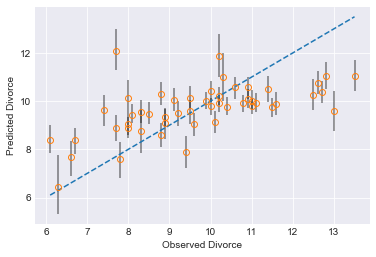

In [23]:
# Code 5.12
fig, ax = plt.subplots();
ax.set(xlabel='Observed Divorce', ylabel='Predicted Divorce');

# if predictions were perfect they'd lie on this line, i.e. observed = predicted divorce
observed_range = [d.Divorce.min(), d.Divorce.max()]
ax.plot(observed_range, observed_range, '--');

# actual observed vs predicted divorce
ax.plot(d.Divorce, mu_mean, 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
ax.vlines(x=d.Divorce, ymin=mu_PI[:, 0], ymax=mu_PI[:, 1], alpha=0.5);

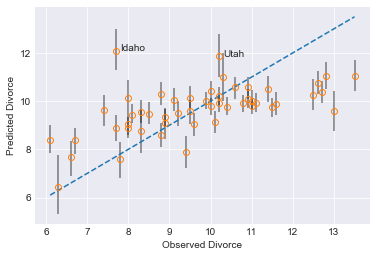

In [24]:
# Code 5.12
fig, ax = plt.subplots();
ax.set(xlabel='Observed Divorce', ylabel='Predicted Divorce');

# if predictions were perfect they'd lie on this line, i.e. observed = predicted divorce
observed_range = [d.Divorce.min(), d.Divorce.max()]
ax.plot(observed_range, observed_range, '--');

# actual observed vs predicted divorce
ax.plot(d.Divorce, mu_mean, 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
ax.vlines(x=d.Divorce, ymin=mu_PI[:, 0], ymax=mu_PI[:, 1], alpha=0.5);

# the same as above, but rolled into one command using 'errorbar' which plots
# data points and error bars

# ax.errorbar(
#     x=d.Divorce,
#     y=mu_mean,
#     yerr=np.abs(mu_PI - mu_mean.reshape(-1, 1)).reshape(2, -1),
#     fmt='o',
#     fillstyle='none',
#     mew=1
# );

# Code 5.13
# no neat 'identify' function, but this one also does the trick without needing to click anywwhere :)
annotate_pd = d[d.Location.isin(['Idaho', 'Utah'])]
annotate_ix = annotate_pd.index.values

for ix in annotate_ix:
    x = d.iloc[ix].Divorce + 0.1 # small offset to keep things legible
    y = mu_mean[ix]
    text = d.iloc[ix].Location

    ax.annotate(s=text, xy=(x, y));

* interpretation: model overpredicts for low divorce rate, underpredicts for high divorce rates
* some data points very far off, e.g. Utah and Idaho
* hard to see actual amount of error. create residual plot instead:

In [25]:
# Code 5.14

# compute residuals
divorce_resid = d.Divorce - mu_mean
# get ordering by divorce rate
o = divorce_resid.sort_values().index.values

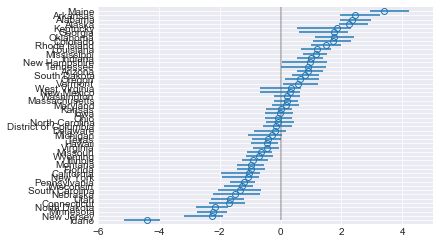

In [26]:
fig, ax = plt.subplots()

# x axis
ax.set_xlim(left=-6, right=5)

# y axis
ax.set_ylim(-1, o.size)
ax.set_yticks(range(0, o.size));
ax.set_yticklabels((d.iloc[o].Location.values));

# perfect prediction demarcation
ax.vlines(x=0, ymin=0, ymax=o.size, alpha=0.3);

# circles
# this seems to work
# ax.plot(divorce_resid.loc[o], range(0, o.size), 'o', fillstyle='none', mew=1);

# add confidence intervals around predictions
# this doesn't plot anything - why?
# eliminated causes: hlines not drawing anything, hlines not working with arrays
# ax.hlines(y=np.arange(0, o.size), xmin=mu_PI[o, 0], xmax=mu_PI[o, 1]);

# use errorbars instead
ax.errorbar(
    x=divorce_resid.loc[o],
    y=range(0, o.size),
    xerr=np.abs(mu_PI[o] - mu_mean[o].reshape(-1, 1)).reshape(2, -1),
    fmt='o',
    fillstyle='none',
    mew=1
);

* **observation: in contrast to book errors appear to not be symmetrical around mean. issue? reason? investigate!**
* **note: using order 'o' everywhere made it all very finicky. probably easier to make new dataframe which contains means and residuals, order that one and then plot from there**
* above plot makes it easier to see where model really goes wrong, e.g. Maine and Idaho
* might be infeasible to plot for large data sets
* another use for these estimates: create new predictor residual plots, i.e. new predictor vs residuals. shows if there's association between new predictor and outcome variable, even after controlling for other factors
* "does not mean that correlation is real. no matter how many predictors you've already included in regression, it's still possible to find spurious correlations with the remaining variation"
* **rethinking: stats, huh, yeah what is it good for?** statistics often asked questions it cannot answer, e.g. "is effect real or spurious?". but: modeling only quantifies uncertainty, conditional on the model ("in the way the model understands the problem"). Determining truth/causation in real world typically needs additional information not contained in model. E.g.: **any correlation between predictor and dependent var can vanish or be reversed by including another new predictor.** Might never find that one crucial predictor if we don't think about it. n:**model not guaranteed to be complete**. All models are vulnerable and need to be critiqued, however good they might look. Model criticism and revision are the **"real test"**, statistical tests are small bits of that process
* **overthinking: simulating spurious association** possible scenario: both outcome $y$ and spurious predictor $x_{spur}$ are influenced by real predictor $x_{real}$ (cf. Bayesian network, easy visualisation). $x_{spur}$ not actually itself correllated with $y$. Multiple regression can determine which predictor is actually relevant. See code below

In [27]:
# Code 5.15

# number of cases
N = 100
# x_real as Gaussian with mean 0 and stddev 1
x_real = np.random.normal(size=N)
# x_spur as Gaussian with mean=x_real
x_spur = np.random.normal(loc=x_real)
# y as Gaussian with mean=x_real
y = np.random.normal(loc=x_real)
# bind together in dataframe
# diverge from book variable name 'd' so as not to overwrite earlier variable
d_spurious = pd.DataFrame(data={
    'x_real': x_real,
    'x_spur': x_spur,
    'y': y
})

d_spurious.head()

,x_real,x_spur,y
0,-0.218046,0.065248,-0.144258
1,-0.063838,-0.191113,0.503896
2,0.763980,0.633557,1.786627
3,0.122061,1.340794,0.807963
4,0.010809,-0.992821,0.540422


* book says: "look at $pairs(d)$ to see correlation between $x_{spur}$ and $y$. however, when fitting model, coefficient for $x_{spur}$ should small and for $x_{real}$ should be close to 1"
* let's try this

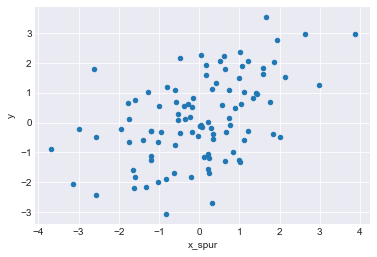

In [28]:
d_spurious.plot.scatter(x='x_spur', y='y');

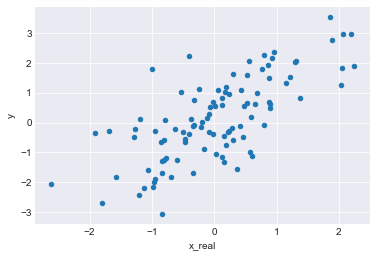

In [29]:
d_spurious.plot.scatter(x='x_real', y='y');

In [30]:
with pm.Model() as m5_spurious:
    bReal = pm.Normal('bReal', mu=0, sd=1)
    bSpur = pm.Normal('bSpur', mu=0, sd=1)
    a = pm.Normal('a', mu=10, sd=10)
    mu = pm.Deterministic('mu', a + bReal * d_spurious.x_real + bSpur * d_spurious.x_spur)
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y = pm.Normal('y', mu=mu, sd=sigma, observed=d_spurious.y)
    
    trace_m5_spurious = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bSpur, bReal]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1103.83draws/s]
The acceptance probability does not match the target. It is 0.8799411705540713, but should be close to 0.8. Try to increase the number of tuning steps.


In [31]:
pm.summary(trace_m5_spurious, varnames=['bReal', 'bSpur', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bReal,1.053081,0.142279,0.003926,0.767039,1.320411,1360.718042,1.001364
bSpur,-0.015803,0.100045,0.002795,-0.204640,0.191758,1412.699976,1.000610
a,0.099237,0.100148,0.002479,-0.106344,0.284556,1767.704638,0.999505
sigma,0.988744,0.072247,0.001645,0.854982,1.131325,1974.264341,1.000940


* **Observation and question:** indeed, coefficient for real predictor is high, for spurious predictor is low. **Why?**. Hypothesis: because multiple regression model finds coefficients for each predictor independently, asking question "what is correlation between this predictor and outcome given we already know all values for all other predictors". if this is correct, then follow-up question: how is this expressed in the mathematical definition?

## 5.2 Masked Relationships
* Multiple predictors: useful for detecting spurious relationships
* Another advantage: measure influence of multiple factors on outcome when influence cannot be detected from bivariate relationships
* common cause: correlated predictors, but one pos. correlated w/ outcome and the other one negatively
* investigate this using data about mammal species and their milk production

In [32]:
# Code 5.16
d = (
    pd
    .read_csv('./data/milk.csv', sep=';')
    .rename(
        columns=lambda colname: colname.replace('.', '_'), # make more pythonic
    )
)
d.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [33]:
d.shape

(29, 8)

* hypothesis: larger brains means higher-energetic milk
* start simple now, consider more subtle statistical issues of cross-species comparison later
* primary variables for now: energy content of milk ("kcal_per_g") and relative brain size ("neocortex_perc"). Later will also use average female body mass ("mass")

In [35]:
with pm.Model() as m5_5:
    sigma = pm.Uniform('sigma', 0, 1)
    bn = pm.Normal('bn', 0, 1)
    a = pm.Normal('a', 0, 100)
    mu = pm.Deterministic('mu', a + bn * d.neocortex_perc)
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed=d.kcal_per_g)
    
    trace_m5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

* this error should be caused by missing values for "neocortex_perc"

In [37]:
# Code 5.18
d.neocortex_perc.head()

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
Name: neocortex_perc, dtype: float64

In [38]:
d.neocortex_perc.isnull().sum()

12

In [39]:
# Code 5.19
dcc = d.dropna()
dcc.shape

(17, 8)

In [40]:
# Code 5.20
with pm.Model() as m5_5:
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    bn = pm.Normal('bn', mu=0, sd=1)
    a = pm.Normal('a', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + bn * dcc.neocortex_perc)
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc.kcal_per_g)
    
    trace_m5_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 188.52draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [41]:
# Code 5.21
pm.summary(trace_m5_5, varnames=['sigma', 'bn', 'a'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.194334,0.039632,0.001512,0.129416,0.274005,471.587769,1.002099
bn,0.005241,0.008435,0.000331,-0.012186,0.020975,512.055433,0.999549
a,0.303102,0.572809,0.022161,-0.751205,1.474871,521.139880,0.999544


* observation: coefficient `bn` super small
* how does change in `neocortex_perc` translate to a predicted change in `kcal_per_g`?

In [42]:
# Code 5.22
# 76 and 55 are the highest and lowest recorded values of neocortex_perc respectively
trace_m5_5['bn'].mean() * (76 - 55)

0.11006132595067931

* expected change in `kcal_per_g` of 0.09. varable range is 0.5 to 0.9, so tiny impact
* even less useful when considering uncertainty around these estimates, see below

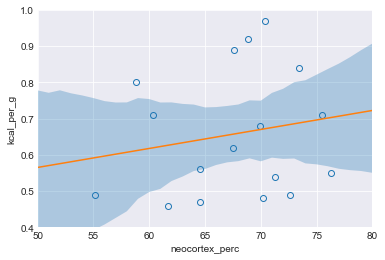

In [43]:
# Code 5.23
np_seq = np.arange(0, 101)

mu = trace_m5_5['a'].reshape(-1, 1) + np.dot(trace_m5_5['bn'].reshape(-1, 1), np_seq.reshape(1, -1))
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=0.11)

fig, ax = plt.subplots()
ax.plot(dcc.neocortex_perc, dcc.kcal_per_g, 'o', fillstyle='none', mew=1);
ax.plot(np_seq, mu_mean);
ax.fill_between(np_seq, y1=mu_pi[:,0], y2=mu_pi[:,1], alpha=0.3);

ax.set_xlim(50, 80);
ax.set_ylim(0.4, 1.0)

ax.set_xlabel('neocortex_perc');
ax.set_ylabel('kcal_per_g');

* weakly positive, but very imprecise. many different slopes possible for these data and this model
* investigate link mass to energy next
* use log(mass). log(x) transforms measurement to order of magnitude, which is often relevant to scaling factors such as mass

In [44]:
# Code 5.24
dcc = dcc.assign(log_mass=np.log(dcc.mass))

In [45]:
# Code 5.25
with pm.Model() as m5_6:
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    bm = pm.Normal('bm', mu=0, sd=1)
    a = pm.Normal('a', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + bm * dcc.log_mass)
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc.kcal_per_g)
    
    trace_m5_6 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_6, varnames=['sigma', 'bm', 'a'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 815.70draws/s] 


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.184926,0.040473,0.001234,0.119200,0.266887,987.140951,0.999936
bm,-0.032100,0.024625,0.000717,-0.087641,0.011552,952.804499,0.999966
a,0.705032,0.060028,0.001618,0.592179,0.826212,1016.913145,1.000123


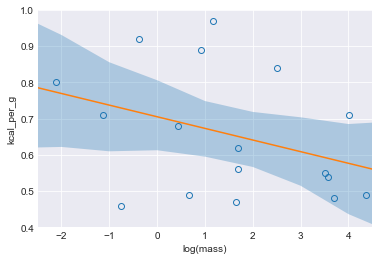

In [46]:
# no code block in the book
bm_seq = np.arange(-5, 6)

mu = trace_m5_6['a'].reshape(-1, 1) + trace_m5_6['bm'].reshape(-1, 1) @ bm_seq.reshape(1, -1)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=0.11)

fig, ax = plt.subplots()
ax.plot(dcc.log_mass, dcc.kcal_per_g, 'o', fillstyle='none', mew=1);
ax.plot(bm_seq, mu_mean);
ax.fill_between(bm_seq, y1=mu_pi[:,0], y2=mu_pi[:,1], alpha=0.3);

ax.set_xlim(-2.5, 4.5);
ax.set_ylim(0.4, 1.0)

ax.set_xlabel('log(mass)');
ax.set_ylabel('kcal_per_g');

* slightly negative correlation
* now, include both predictors

In [47]:
# Code 5.26
with pm.Model() as m5_7:

    a = pm.Normal('a', mu=0, sd=100)
    bm = pm.Normal('bm', mu=0, sd=1)
    bn = pm.Normal('bn', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + bm * dcc.log_mass + bn * dcc.neocortex_perc)
    
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu, sd=sigma, observed=dcc.kcal_per_g)
    
    trace_m5_7 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_7, varnames=['sigma', 'bm', 'bn', 'a'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:27<00:00, 143.52draws/s]
The acceptance probability does not match the target. It is 0.8800372951496442, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,0.141006,0.029222,0.001119,0.093281,0.199128,670.307149,1.000173
bm,-0.095937,0.027166,0.001010,-0.147558,-0.038188,625.283412,1.000805
bn,0.027815,0.008559,0.000357,0.009800,0.044090,527.703881,1.002426
a,-1.078527,0.551259,0.022881,-2.113276,0.079436,538.440239,1.002464


* influence of both predictors has increased by including both
* mass now entirely negative, brain size now entirely positive, both increased quantity
* investigate impact of brain size on energy when keeping mass constant. counterfactual plot

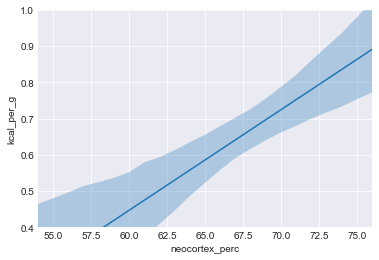

In [48]:
# Code 5.27

mean_log_mass = dcc.log_mass.mean()
np_seq = np.arange(0, 101)
pred_data = pd.DataFrame({'neocortex_perc': np_seq, 'log_mass': mean_log_mass})

mu = trace_m5_7['a'].reshape(-1, 1) + trace_m5_7['bm'].reshape(-1, 1) @ pred_data.log_mass.values.reshape(1, -1) + trace_m5_7['bn'].reshape(-1, 1) @ pred_data.neocortex_perc.values.reshape(1, -1) 
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=0.11)

fig, ax = plt.subplots()
# ax.plot(dcc.log_mass, dcc.kcal_per_g, 'o', fillstyle='none', mew=1);
ax.plot(np_seq, mu_mean);
ax.fill_between(np_seq, y1=mu_pi[:,0], y2=mu_pi[:,1], alpha=0.3);

ax.set_xlim(54, 76);
ax.set_ylim(0.4, 1.0)

ax.set_xlabel('neocortex_perc');
ax.set_ylabel('kcal_per_g');

* let's do the for the other predictor, keep neocortex_perc fixed and vary log(mass)

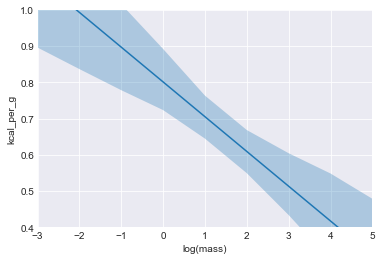

In [49]:
# no code block in the book for this

mean_neocortex_perc = dcc.neocortex_perc.mean()
log_mass_seq = np.arange(-5, 6)
pred_data = pd.DataFrame({'neocortex_perc': mean_neocortex_perc, 'log_mass': log_mass_seq})

mu = trace_m5_7['a'].reshape(-1, 1) + trace_m5_7['bm'].reshape(-1, 1) @ pred_data.log_mass.values.reshape(1, -1) + trace_m5_7['bn'].reshape(-1, 1) @ pred_data.neocortex_perc.values.reshape(1, -1) 
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=0.11)

fig, ax = plt.subplots()
ax.plot(log_mass_seq, mu_mean);
ax.fill_between(log_mass_seq, y1=mu_pi[:,0], y2=mu_pi[:,1], alpha=0.3);

ax.set_xlim(-3, 5);
ax.set_ylim(0.4, 1.0)

ax.set_xlabel('log(mass)');
ax.set_ylabel('kcal_per_g');

* now probably the most interesting but: **the summary. why do we see this, what did we learn?**
* by itself, no predictor has strong influence on outcome
* combined they each have a strong influence, in opposing directions
* these observations typical of cases where 1 predictor has positive correlation with the outcome, 1 predictor has negative correlation w/ outcome and both predictors have pos. corr. w/ each other
* so, on average, mass has small neg corr w/ energy, neocortex perc. has small pos. corr. however, more massive monkeys also tend to have higher neocortex perc
* multivariate regression controls for other predictor when finding coefficient of one predictor. e.g. it asks 'for monkeys w/ high mass, how are neocortex perc and milk energy linked'? and mutatis mutandis for neocortex perc.
* we see that for a given monkey mass, higher neocortex perc. has strong impact on milk energy (mut. mutand. for other predictor)
* my own example: pred 1: weight, pred 2: height. outcome: climbing performance.
* higher weight on average means lower climbing perf (more mass to push up)
* higher height on average means higher climbing perf (more reach)
* positive correlation between those: taller people tend to be heavier
* multivariate model will find stronger effects of predictors: if assuming person is tall then stronger negative effect of increased weight on climbing perf
* **overthinking: simulating a masking relationship** 
* why would mass and neocortex be correlated? possibly b/c larger animals live longer, so favoring learning makes more sense
* pred1 and pred2 can be related in many ways. maybe underlying cause influencing both. or maybe they impact one another. or maybe pred1 influences pred2, but pred2 also has internal processes
* stronger correlation between predictors = harder to tease apart for statistical procedures
* correlation = 1 -> both predictors contain same information
* can simulate masking relationship in code, see below

In [50]:
# Code 5.28
n = 100
rho = 0.7
x_pos = np.random.normal(size=n)
x_neg = np.random.normal(rho*x_pos, np.sqrt(1 - rho**2), n)
y = np.random.normal(x_pos - x_neg, size=n)
d = pd.DataFrame({'y': y, 'x_pos': x_pos, 'x_neg': x_neg})

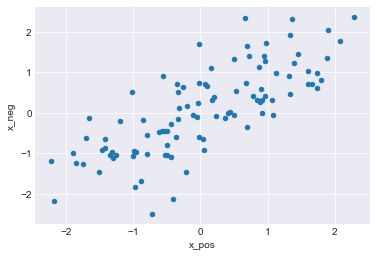

In [51]:
d.plot.scatter('x_pos', 'x_neg');

* (skipping the bit where I fit two bivariate and one multivariate model for multiple values of `rho` and inspect posteriors of coefficients)

## 5.3. When adding variables hurts
* Statistical reasons for not just including all available variables in regression: multicollinearity, treatment bias and overfitting
* Multicollinearity: v. strong correlation between two or more predictors.
* Result: posteriors for those predictors have high uncertainty from miniscule to huge association, even though all predictors are actually strongly correlated w/ outcome
* Root cause: how statistical control works (**how does it work?**)

### 5.3.1. multicollinear legs
* Example: predicting individual's height from both left leg size and right leg size
* Certainly correlated w/ both, but weird effect appears when including both predictors

In [52]:
# Code 5.29

# number of individuals
n = 100
# sim total height of each
height= np.random.normal(loc=10, scale=2, size=n)
# leg as proportion of height
leg_prop = np.random.uniform(low=0.4, high=0.5, size=n)
# sim left leg as proportion + error
leg_left = leg_prop * height + np.random.normal(loc=0, scale=0.02, size=n)
# sim right leg as proportion + error
leg_right = leg_prop * height + np.random.normal(loc=0, scale=0.02, size=n)

# combine
d = pd.DataFrame({'height': height, 'leg_left': leg_left, 'leg_right': leg_right})

In [53]:
d.head()

,height,leg_left,leg_right
0,10.684843,4.521989,4.540472
1,9.036463,4.185751,4.143363
2,12.615441,6.208137,6.210111
3,10.439807,5.156723,5.108015
4,8.083860,3.900511,3.901372


In [54]:
# Code 5.30
with pm.Model() as m5_8:
    sigma = pm.Uniform('sigma', 0, 10)
    br = pm.Normal('br', 2, 10)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    
    mu = pm.Deterministic('mu', a + bl * d.leg_left + br * d.leg_right)
    
    height = pm.Normal('height', mu, sigma, observed = d.height)
    
    trace_m5_8 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [02:23<00:00, 27.92draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
br,2.762719,2.163399,0.076764,-1.888685,6.501475,745.561197,0.999877
bl,-0.723312,2.157764,0.076652,-4.657115,3.740603,744.675124,0.999852
a,0.915819,0.324216,0.009194,0.310391,1.547257,1309.493501,1.000114
sigma,0.629947,0.045224,0.001297,0.547596,0.729937,1226.786673,0.999786
mu__0,10.189058,0.077399,0.002193,10.031235,10.330918,1380.280457,0.999517
mu__1,9.335162,0.113613,0.003419,9.128522,9.568590,942.104378,1.000392
mu__2,13.582192,0.145899,0.003727,13.310844,13.874377,1546.627892,0.999616
mu__3,11.297911,0.130140,0.003889,11.040471,11.541375,973.744963,0.999778
mu__4,8.872928,0.074003,0.001897,8.721278,9.013723,1631.610938,1.000241
mu__5,9.571985,0.072066,0.001986,9.432084,9.716456,1499.723435,0.999684


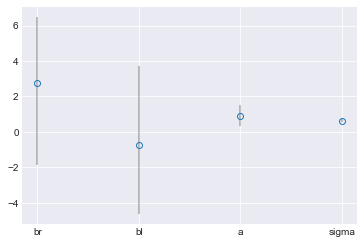

In [55]:
# Code 5.31
summary_m5_8 = pm.summary(trace_m5_8)

varnames = ['br', 'bl', 'a', 'sigma']
plot_pd = summary_m5_8.loc[varnames]

fig, ax = plt.subplots();
ax.plot(plot_pd['mean'], 'o', fillstyle='none', mew=1);
ax.vlines(varnames, ymin=plot_pd['hpd_2.5'], ymax=plot_pd['hpd_97.5'], alpha=0.3);


# NOTE: can I make this in an easier way with one call to pandas or seaborn plotting functionality?

* super weird distribution. expect high correlation of both legs w/ height
* however: **this outcome is right answer to question we asked**. that question is: **how much do we learn about height by knowing the length of the curent leg, given we know the length of the other leg already?**
* weird question -> weird, but logical, answer, as given by posterior
* posterior considers all possible combinations of leg lengths and assigns relative plausibilities to those, given this model and these data points
* look at bivariate distributions instead to learn:

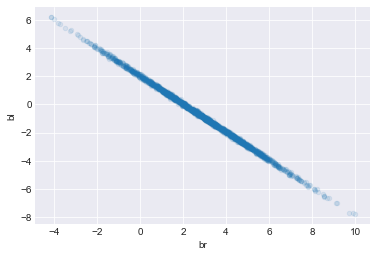

In [56]:
# Code 5.32

# Note: plot in book is empty and it's unclear what exactly the `extract.samples` function does. best guess here

post = pm.trace_to_dataframe(trace_m5_8)[['br', 'bl']]
post.plot(x='br', y='bl', kind='scatter', alpha=0.1);

* this is displaying the posterior of these two parameters
* observation: when one is large the other one must be small
* reason: they encode nearly the same information. if model must include both there are near-infite combinations of these predictors that produce same predictions
* another way to think about this is that model is as follows:
$$
y_i \sim \mathfrak{N}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i
$$
* `y` is outcome, `x` is single predictor, but is assigned two different coefficients
* can be rewritten as:
$$
y_i \sim \mathfrak{N}(\mu_i, \sigma) \\
\mu_i = \alpha + x_i * (\beta_1 + \beta_2)
$$
* $\beta_1$ and $\beta_2$ can never be separated as they never have separate influence on outcome, only their sum is impacting the outcome. thus: posterior shows nearly infinite combinations which all give proper weight to the sum of both predictors
* inspect posterior of sum to see that model has done a good job at this:

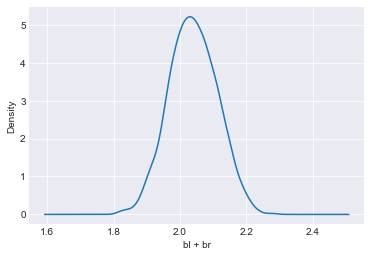

In [65]:
# Code 5.33
ax = (post.bl+post.br).plot.kde()
ax.set_xlabel("bl + br");

* this looks about right: association a little over 2, with small uncertainty
* let's fit a single-predictor model, should get same results:

In [66]:
# Code 5.34
with pm.Model() as m5_9:
    sigma = pm.Uniform('sigma', 0, 10)
    bl = pm.Normal('bl', 2, 10)
    a = pm.Normal('a', 10, 100)
    
    mu = pm.Deterministic('mu', a + bl * d.leg_left)
    
    height = pm.Normal('height', mu, sigma, observed = d.height)
    
    trace_m5_9 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 511.80draws/s]
The acceptance probability does not match the target. It is 0.8798806785239274, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bl,2.034934,0.067890,0.002839,1.904228,2.171287,475.304710,0.999562
a,0.932693,0.304975,0.012883,0.337407,1.526758,453.112026,0.999752
sigma,0.632426,0.045463,0.001329,0.547425,0.724183,1135.653353,1.000572
mu__0,10.134641,0.063191,0.001348,10.014872,10.255115,2259.626580,1.000984
mu__1,9.450419,0.064227,0.001637,9.328868,9.574067,1602.759811,1.001156
mu__2,13.565839,0.138015,0.004998,13.313226,13.851905,713.070210,0.999624
mu__3,11.426283,0.081145,0.002271,11.261731,11.585533,1298.913848,1.000167
mu__4,8.869974,0.071093,0.002200,8.730596,9.005016,882.876959,1.001014
mu__5,9.532244,0.063675,0.001575,9.416122,9.658705,1708.192920,1.001158
mu__6,10.791141,0.069614,0.001645,10.657858,10.927027,1818.042923,1.000556


* indeed, inspecting mean and HPD for the `bl` parameter it is now behaving as expected
* **bottom line: including two or more highly correlated variables in model can have confusing results** 
* posterior is not wrong, model is telling you to unask the question because it cannot answer it
* actually, that is very useful information
* model can still be useful for prediction
* model cannot say which leg is more important

### 5.3.2. Multicollinear milk
* leg example: easy to see that both predictors contain same information
* in real-world often not obvious, might not be aware of that
* then: might mis-read output of model and think that neither predictor has useful information
* investigate this with real data here:

In [78]:
# Code 3.35

d = (
    pd
    .read_csv('./data/milk.csv', sep=';')
    .rename(
        columns=lambda colname: colname.replace('.', '_'), # make more pythonic
    )
)
d.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [87]:
# Code 5.36

with pm.Model() as m5_10:
    sigma = pm.Uniform('sigma', 0, 10)
    bf = pm.Normal('bf', 0, 1)
    a = pm.Normal('a', 0.6, 10)
    mu = pm.Deterministic('mu', a + bf * d.perc_fat)
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed=d.kcal_per_g)
    
    trace_m5_10 = pm.sample(draws=1000, tune=1000)

with pm.Model() as m5_11:
    sigma = pm.Uniform('sigma', 0, 10)
    bl = pm.Normal('bl', 0, 1)
    a = pm.Normal('a', 0.6, 10)
    mu = pm.Deterministic('mu', a + bl * d.perc_lactose)
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed=d.kcal_per_g)
    
    trace_m5_11 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 598.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 411.89draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [85]:
pm.summary(trace_m5_10, varnames=['bf', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bf,0.010060,0.001035,0.000035,0.007958,0.012075,708.179974,1.000798
a,0.299598,0.037825,0.001284,0.227755,0.379171,790.649507,1.001013
sigma,0.079594,0.012149,0.000387,0.058295,0.102533,994.653950,0.999511


In [86]:
pm.summary(trace_m5_11, varnames=['bl', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bl,-0.010586,0.000909,0.000031,-0.012462,-0.008891,671.542179,0.999629
a,1.166841,0.046573,0.001577,1.072937,1.255225,682.229905,0.999716
sigma,0.066478,0.009427,0.000298,0.049049,0.083984,984.789226,0.999999


* observation: `bl` and `bf` are 'mirror images' of each other, with means and hpd intervals mirrored at the 0-axis, with `bf` being all positive and `bl` being all negative
* wisdom from the book: `bl` and `bf` small in absolute value, but still have big impact on outcome variable. rationale: predictors are percentages. also note: absolute magnitude of regression not always relevant, impact on outcome depends on combination of parameter and data
* advise: **compute or plot predictions, unless all predictors standardized. even then, probably better idea to plot than to trust intuitions**
* conclusions from this: more fat = more energy, more lactose = less energy, good predictors. but, observe effect of including both:

In [88]:
# Code 5.37

with pm.Model() as m5_12:
    sigma = pm.Uniform('sigma', 0, 10)
    bf = pm.Normal('bf', 0, 1)
    bl = pm.Normal('bl', 0, 1)
    a = pm.Normal('a', 0.6, 10)
    mu = pm.Deterministic('mu', a + bf * d.perc_fat + bl * d.perc_lactose)
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed=d.kcal_per_g)
    
    trace_m5_12 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, bf, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:22<00:00, 204.83draws/s]


In [90]:
pm.summary(trace_m5_12, varnames=['bl', 'bf', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bl,-0.008804,0.002759,0.000108,-0.014449,-0.003443,646.969336,1.000053
bf,0.001849,0.002728,0.000105,-0.003760,0.007058,654.456425,1.000056
a,1.015790,0.227414,0.008892,0.598818,1.512200,640.500728,1.000078
sigma,0.067049,0.009271,0.000332,0.049387,0.084341,632.889609,0.999595


* suddenly, effects much smaller and intervals wider
* cause: both predictors contain nearly same information, just as in leg length example. same effect of including both in same model

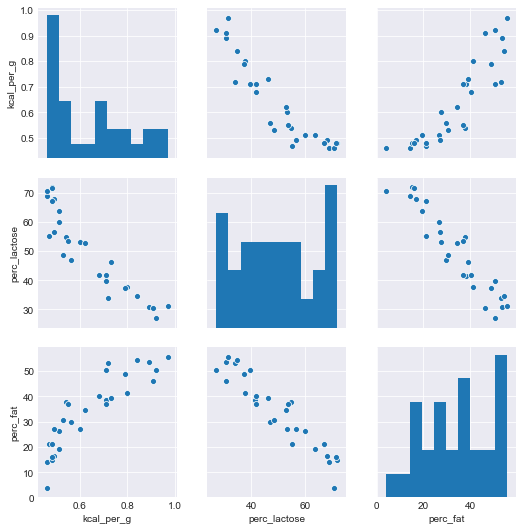

In [95]:
# Code 5.38

sns.pairplot(d[['kcal_per_g', 'perc_lactose', 'perc_fat']]);

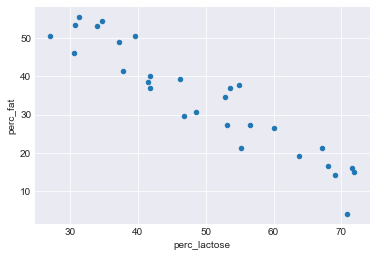

In [98]:
# criticism: I think this is a pretty confusing plot. Story would have been easier to tell by pulling pairs apart
# for example, the point the book wants to make: strong negative correlation between predictors. the plot that tells
# this story more clearly:

d.plot.scatter(x='perc_lactose', y='perc_fat');

* observation: fat/lactose strongly negatively correlated, contain much of same information. both are also correlated w/ outcome, so tell us something interesting about energy content. including either is helpful, including both is not
* reason behind this: **if knowing one learning about the other does not help much**

In [101]:
# Code 5.39
d[['perc_lactose', 'perc_fat']].corr()

,perc_lactose,perc_fat
perc_lactose,1.000000,-0.941637
perc_fat,-0.941637,1.000000


* **no easy way to say at what point correlation becomes too high**, does not have to be very strong to affect analysis
* **what matters is correlation remaining after accounting for other predictors**, not just between two variables
* in this small setting can be tested by constructing predictor that has varying degrees of correlation with other predictor and fitting model each time, see Figure 5.10 (p. 149) in book for outcome
* observation: exponential growth of stddev of posterior interval based on increasing correlation
* **how to deal with multicollinearity? best advise: be aware of it**. can check predictors against each other, e.g. in pairwise correlation plot
* however: correlated vars might not be redundant, combination with other vars might reveal unique information. thus: impossible to say just from matrix of scatterplots. still, if stddev inflates after including both vars this indicates issue
* different fields have different traditions on how to handle multicollinearity, e.g. **principle components** or **factor analysis**, other fields treat that as black magic b/c of hidden decisions
* conservative approach: show that model using either of correlated predictors produces similar outcomes, gives confidence that all relevant effects are captures
* multicollinearity is member of whole group of problems sometimes called **non-identifiability**. def: param is non-identifiable if combination of model and data do not allow param value to be estimated
* source: sometimes model coding issues, but often model coded correctly and still params non-identifiable
* **no general guarantee that data has anything to say about model parameters** in that case posterior will be wide. Not wrong: right answer to asked question. But: might also be symptom of other problem, e.g. multicollinearity. in that case check correlation between parameters to prevent **misinterpreting what model means**
* **rethinking: idenficiation guaranteed; comprehension up to you**: technically, all parameters in Bayesian models are identified as long as posterior for each param sums to one (= *is proper*). However, still doesn't necessarily make sense, so better term would be **weakly identified**
* **overthinking: simulating collinearity** see code below. uses flat priors, which are bad, when using informative priors then rise in in std dev can be much slower

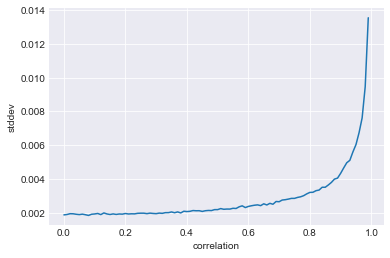

In [138]:
# Code 5.40

# based on https://render.githubusercontent.com/view/ipynb?commit=311da5548a958574b9baf29646458871062284aa&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c6f637461766f6469612f537461746973746963616c2d52657468696e6b696e672d776974682d507974686f6e2d616e642d50794d43332f333131646135353438613935383537346239626166323936343634353838373130363232383461612f4368705f30352e6970796e62&nwo=aloctavodia%2FStatistical-Rethinking-with-Python-and-PyMC3&path=Chp_05.ipynb&repository_id=67766282&repository_type=Repository#Code-5.40

def sim_coll(r, df):
    df = df.assign(
        x = np.random.normal(
            loc=df.perc_fat, 
            scale=np.sqrt((1.0 - r**2) * df.perc_fat.var())
        )
    )

    x_mtrx = np.column_stack((df.perc_fat, df.x))

    m = smf.OLS(df.kcal_per_g, x_mtrx).fit()

    cov = m.cov_params()

    return (np.diag(cov)[1])**0.5

def rep_sim_coll(r, n, df):
    stddev = [sim_coll(r, d) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 1, 0.01)
stddev = [rep_sim_coll(r=r, n=100, df=d) for r in r_seq]

plt.plot(r_seq, stddev);
plt.xlabel('correlation');
plt.ylabel('stddev');

### 5.3.3. Post-treatment bias

* seen before in this chapter: **omitted variable bias**, inference mistakes due to missing variables
* less often paid attention to: **post-treatment bias**, inference mistakes due to including variables that are consequences of other variables
* ex: soil treatment. outcome var is final height of plant. fungus presence is also measured, but depends on soil treatment, so is a consequence and thus post-treatment variable.
* illustrate through simulation

In [168]:
# Code 5.41

# number of plants
n = 100

# simulate initial heights
h0 = np.random.normal(10, 2, n)

# assign treatments and simulate fungus and growth
treatment = np.zeros(n)
treatment[int(n/2):] = 1

fungus = np.random.binomial(n=1, p=0.5 - treatment*0.4)

h1 = h0 + np.random.normal(5 - 3 * fungus, size=n)

# compose a clean data frame
d = pd.DataFrame({'h0': h0, 'h1':h1, 'treatment': treatment, 'fungus': fungus})

d.head()

,h0,h1,treatment,fungus
0,10.881482,14.642662,0.0,0
1,13.663246,17.541280,0.0,1
2,10.632620,15.520045,0.0,0
3,10.251783,14.279202,0.0,0
4,10.793065,12.684702,0.0,1


In [172]:
# Code 5.42

with pm.Model() as m5_13:
    
    bh =  pm.Normal('bh', 0, 10)
    bt = pm.Normal('bt', 0, 10)
    bf = pm.Normal('bf', 0, 10)
    
    a = pm.Normal('a', 0, 100)
    
    mu = pm.Deterministic('mu', a + bh * d.h0 + bt * d.treatment + bf * d.fungus)
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    h1 = pm.Normal('h1', mu, sigma, observed=d.h1)
    
    trace_m5_13 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_13, varnames=['bh', 'bt', 'bf', 'a', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bf, bt, bh]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 358.08draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bh,1.052233,0.045792,0.001487,0.966107,1.138736,901.281637,0.999905
bt,0.234035,0.214762,0.007247,-0.223970,0.617402,905.125238,1.000799
bf,-2.590305,0.248681,0.007940,-3.044973,-2.106523,1004.485348,0.999830
a,4.214219,0.509732,0.017979,3.205985,5.150755,835.311506,1.000228
sigma,0.945085,0.068977,0.001795,0.816797,1.080544,1439.321053,1.000392


* treatment has low effect with wide interval, even though we know it has big effect b/c we set up data generation process that way. h0 and fungus have high effect
* explanation: fungus mostly consequence of treatment, i.e. post-treatment variable
* model answers question: given that we know if there is fungus, how much does treatment tell us?
* in that case, treatment tells us very little, b/c information is alread in fungus var. treatment has effect on final height through fungus var
* however, actual question of experiment is effect of treatment on plant growth. thus omit fungus var:

In [173]:
# Code 5.43

with pm.Model() as m5_14:
    
    bh =  pm.Normal('bh', 0, 10)
    bt = pm.Normal('bt', 0, 10)
    
    a = pm.Normal('a', 0, 100)
    
    mu = pm.Deterministic('mu', a + bh * d.h0 + bt * d.treatment)
    
    sigma = pm.Uniform('sigma', 0, 10)
    
    h1 = pm.Normal('h1', mu, sigma, observed=d.h1)
    
    trace_m5_14 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_14, varnames=['bh', 'bt', 'a', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bt, bh]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 393.51draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bh,1.118510,0.070483,0.002501,0.987743,1.256566,667.061740,1.000309
bt,1.421019,0.295954,0.008281,0.847103,1.979742,1374.938998,0.999873
a,2.152845,0.752577,0.027413,0.633274,3.556568,645.524071,0.999810
sigma,1.420878,0.108333,0.002826,1.216786,1.636847,1240.740688,1.000169


* observation: now large effect of treatment, as it's supposed to be
* useful to control for pre-treatment differences, e.g. height of the plant before treatment. we're interested in the change, not absolute height
* issues w/ post-treatment vars apply to both experiments and observational studies, but in obs. studies possibly hard to say which vars are post-treatment
* **rethinking: mode comparison doesn't help.** next chapter: model comparison through information criteria. help to select models, but would not resolve above post-treatment issues. `m5_13` would have better predictive capabilities, but it's **misleading b/c it asks the wrong question**. **"no statistical procedure can substitue for scientific knowledge and attention to it"**

## 5.4 Categorical variables
Categorical variables = ones taking on a number of discrete values, e.g. sex, geographic region, language, ...

Commonly called **factors**

Easy to include but often hard to interpret. Understanding mechanism of how they are included in model makes interpretation easier

### 5.4.1. Binary categories
Simplest case: only two possible values, e.g. sex. Re-inspect Kalahari data of Ch. 4

In [176]:
# Code 5.44

d = (
    pd
    .read_csv('./data/Howell1.csv', sep=';')
)

d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


`male` is new predictor. it's a **dummy variable**: mechanism to encode categorical information into quantitative models.

model def:
$$
h_i \sim \mathfrak{N}(\mu_i, \sigma) \\
\mu_i = \alpha + \beta_m m_i \\
\alpha \sim \mathfrak{N}(178, 100) \\
\beta_m \sim \mathfrak{N}(0, 10) \\
\sigma \sim \mathfrak{U}(0, 50)
$$

$m_i = 1$ iff subject is male. thus $\beta_m$ only has effect for these data points

In [184]:
# Code 5.45

with pm.Model() as m5_15:
    a = pm.Normal('a', 178, 100)
    bm = pm.Normal('bm', 0, 10)
    mu = pm.Deterministic('mu', a + bm * d.male)
    
    sigma = pm.Uniform('sigma', 0, 50)
    
    height = pm.Normal('height', mu, sigma, observed=d.height)
    
    trace_m5_15 = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_15, varnames=['sigma', 'bm', 'a'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 643.73draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,27.415944,0.826583,0.020833,25.901725,29.030863,1290.330742,1.003959
bm,7.365429,2.311356,0.064263,3.045672,11.839127,1231.294975,0.999507
a,134.755240,1.607562,0.043766,131.578697,137.910135,1221.786380,0.999648


Here: `a` is now avg female height: ca 135cm. Reason: $\mu_i = \alpha + \beta_m * 0 = \alpha$ for females, where $m_i = 0$. `bm` is avg mail/female difference, add this to `a` to get avg male height of ca 142cm.

How to get uncertainty around male height? Can't just add uncertainty around `a` and `bm` as these are correllated. Sample from posterior instead

In [187]:
# Code 5.46

mu_male = trace_m5_15['a'] + trace_m5_15['bm']
pm.hpd(mu_male, alpha=0.11)

array([139.4028702 , 144.85641114])

using posterior samples always works, regardless of correlation :)

**overthinking: re-parameterizing the model:** change parameterization (=setup) of model, use separate parameters for male and female:

$$
h_i \sim \mathfrak{N}(\mu_i, \sigma) \\
\mu_i = \alpha_f(1 - m_i) + \alpha_m m_i
$$

In [188]:
# Code 5.47

with pm.Model() as m5_15b:
    am = pm.Normal('am', 178, 100)
    af = pm.Normal('af', 178, 100)
    mu = pm.Deterministic('mu', af*(1-d.male) + am*d.male)
    
    sigma = pm.Uniform('sigma', 0, 50)
    
    height = pm.Normal('height', mu, sigma, observed=d.height)
    
    trace_m5_15b = pm.sample(draws=1000, tune=1000)
    
pm.summary(trace_m5_15b, varnames=['sigma', 'am', 'af'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, af, am]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1374.37draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,27.425482,0.844080,0.013805,25.794580,29.047499,3107.048419,0.999932
am,142.341407,1.689983,0.032241,139.068047,145.699289,2946.695159,0.999510
af,134.650939,1.597807,0.030360,131.587624,137.708260,2867.686597,0.999773


now `af` is the average female height (with associated uncertainty) and `am` is avg male height (w. uncertainty). compare rearranged formula:

$$
\mu_i = \alpha_f + (\alpha_m - \alpha_f) m_i
$$

where now indeed $(\alpha_m - \alpha_f)$ takes the place of what used to be $\beta_m$

### 5.4.2. Many categories
Generally need $1 -k$ dummy vars to encode $k$ unique values ('levels') of cat. var. ('factor'), last unique value is intercept

with milk data:

In [190]:
# Code 5.48

d = (
    pd
    .read_csv('./data/milk.csv', sep=';')
    .rename(
        columns=lambda colname: colname.replace('.', '_'), # make more pythonic
    )
)

d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

make dummy for new world monkey:

In [200]:
# Code 5.49

d = d.assign(nwm = (d.clade == 'New World Monkey').astype(int))
d.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc,nwm
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0


In [201]:
# Code 5.50

d = d.assign(owm = (d.clade == 'Old World Monkey').astype(int))
d = d.assign(s = (d.clade == 'Strepsirrhine').astype(int))

d.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc,nwm,owm,s
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0,0,1
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0,0,1
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0,0,1
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0,0,1
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0,0,1


if using dummy var for 'ape' will create non-identifable model **why?**

model based on these dummy vars actually defines 4 different models, one for each unique value:

$$
\text{ape model } \mu_i = \alpha \\
\text{new world monkey model} \mu_i = \alpha + \beta_{nwm} \\
\text{old world monkey model} \mu_i = \alpha + \beta_{owm} \\
\text{strepsirrhine} \mu_i = \alpha + \beta_{s} 
$$

fit model with all these vars:

In [220]:
def summarize_interesting(trace):
    """
    For mcmc trace: call pm.summary for interesting subset of variables, i.e.: no auto-generated ones and no
    mu__N.
    """
    # transform to dataframe first b/c this transforms single 'mu' variable of trace into many 'mu__N' cols of dataframe
    # which makes it easier to filter them
    return pm.summary(
        trace, 
        varnames=[col for col in pm.trace_to_dataframe(trace).columns if not '__' in col]
    )

In [241]:
# Code 5.51

with pm.Model() as m5_16:
    sigma = pm.Uniform('sigma', 0, 10)
    
    b_s = pm.Normal('b_s', 0, 1)
    b_owm = pm.Normal('b_owm', 0, 1)
    b_nwm = pm.Normal('b_nwm', 0, 1)
    
    a = pm.Normal('a', 0.6, 10)
    
    mu = pm.Deterministic('mu', a + b_nwm * d.nwm + b_owm * d.owm + b_s * d.s)
    
    kcal_per_g = pm.Normal('kcal_per_g', mu, sigma, observed=d.kcal_per_g)
    
    trace_m5_16 = pm.sample(draws=1000, tune=1000)

summarize_interesting(trace_m5_16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b_nwm, b_owm, b_s, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 614.83draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b_s,-0.036889,0.073261,0.001984,-0.183105,0.109813,1192.866979,0.999543
b_owm,0.240804,0.069402,0.002014,0.109466,0.382491,1072.867439,0.999718
b_nwm,0.166677,0.061781,0.001905,0.044743,0.287659,1097.446937,0.999795
a,0.546572,0.043921,0.001397,0.456413,0.631165,895.933791,0.999682
sigma,0.129806,0.019518,0.000529,0.098626,0.172461,1397.081563,0.999703


`a` is estimate for apes, others are offsets from that

get posteriors for estimates for other clades:

In [242]:
# Code 5.52

post = pm.trace_to_dataframe(trace_m5_16)

mu = pd.DataFrame(
    data = {
        'ape': post.a,
        'nwm': post.a + post.b_nwm,
        'owm': post.a + post.b_owm,
        's': post.a + post.b_s
    }
)

mu.aggregate(['mean', 'std', pm.hpd]).T

,mean,std,hpd
ape,0.546572,0.043932,"[0.45641344997930133, 0.6311652059485754]"
nwm,0.713249,0.0444431,"[0.6275675489445534, 0.805568947309792]"
owm,0.787376,0.0530168,"[0.6870385429614352, 0.8944834066458845]"
s,0.509684,0.0567146,"[0.38843219361799153, 0.6126960381290855]"


`mu` now contains posterior samples of mean milk energy per clade

reparameterize to inspect difference between 2 monkey groups instead of monkey and ape:

In [247]:
# Code 5.53

diff_nwm_owm = mu.nwm - mu.owm
diff_nwm_owm.quantile(q=[0.025, 0.5, 0.975])

0.025   -0.201855
0.500   -0.073996
0.975    0.066293
dtype: float64

working w/ full posterior also yields posterior distribution over difference between these two kinds of monkeys, no uncertainty discarded in the process

**rethinking: differences and statistical significance.** common mistake: 2 params, one far from 0 ("significant") other not far from 0 ("insignificant"). this does **not** mean that there difference is significant. also issue for Bayesian analysis. need to compute difference (**contrast**). not enough to observe that one slope overlaps w/ 0 and another is reliably higher than 0. 

**note: don't understand example**. book says that "$0.13 \pm 0.10$ overlaps a lot with zero". how? $0.13 - 0.10 = 0.03$, right?

source of issue in non-Bayesian sig. testing setting: sig. testing only powerful in one dimension: difference from the null. If not significant then value might overlap a lot with zero, but also with many other values, does not have to be all close to zero. value is uncertain. 

more fundamental mistake in interpreting stat. significance: mistake of accepting null hypothesis. when parameter is not sig. different from zero some authors say "found no difference" or "no effect".  it means ignoring all uncertainty around parameter and using 0 as point estimate. **illogical and common** (niklas: this means accepting null hypothesis.)

### 5.4.3. Adding regular predictor variables
just add them to equation for the mean, e.g. adding percent_fat to model with dummy vars for different clades:

$$
\mu_i = \alpha + \beta_{nwm} * \text{NWM}_i + \beta_{owm} * \text{OWM}_i + \beta_s * S_i + \beta_f F_i
$$

## 5.4.4. Another approach: unique intercepts
make vector of intercept parameters and based on that **index variable** to coneptualize categorical variable:

In [251]:
d = d.assign(clade_id = pd.Categorical(d.clade).codes)
d.head()

,clade,species,kcal_per_g,perc_fat,perc_protein,perc_lactose,mass,neocortex_perc,nwm,owm,s,clade_id
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0,0,1,3
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0,0,1,3
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0,0,1,3
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0,0,1,3
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0,0,1,3


In [254]:
# Code 5.55

# adapted from here: https://render.githubusercontent.com/view/ipynb?commit=311da5548a958574b9baf29646458871062284aa&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c6f637461766f6469612f537461746973746963616c2d52657468696e6b696e672d776974682d507974686f6e2d616e642d50794d43332f333131646135353438613935383537346239626166323936343634353838373130363232383461612f4368705f30352e6970796e62&nwo=aloctavodia%2FStatistical-Rethinking-with-Python-and-PyMC3&path=Chp_05.ipynb&repository_id=67766282&repository_type=Repository#Code-5.55

with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10)
    mu = pm.Deterministic('mu', a)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d.kcal_per_g)
    trace_m5_16_alt = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1414.51draws/s]


In [256]:
summarize_interesting(trace_m5_16_alt)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.641205,0.031092,0.000733,0.574786,0.700027,1918.805377,0.999600
sigma,0.169229,0.023432,0.000589,0.125479,0.214852,1714.577952,1.000863


**above output really weird, taken from official pymc3 translation - how does this related to what's in the book?**

## 5.5. Ordinary least squares and lm
OLS = way of estimating parameters of linear regressions. instead of search for params that maximize posterior instead of find params that minimize sum of squared residuals. often funtionally equivanlt to maximizing posterior or maximizing likelihood

### 5.5.1. design formulas
R-specific

### 5.5.2. Using lm
Code 5.56 through Code 5.61: illustrations of R's `lm` functionality

#### 5.5.2.2. Categorical variables
R-specific

#### 5.5.2.3. Transforming variables first
R-specific

#### 5.5.2.4. No estimate for sigma
R-specific

### 5.5.3. Building map formulas from lm formulas

In [258]:
# Code 5.62

# copied from https://render.githubusercontent.com/view/ipynb?commit=311da5548a958574b9baf29646458871062284aa&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f616c6f637461766f6469612f537461746973746963616c2d52657468696e6b696e672d776974682d507974686f6e2d616e642d50794d43332f333131646135353438613935383537346239626166323936343634353838373130363232383461612f4368705f30352e6970796e62&nwo=aloctavodia%2FStatistical-Rethinking-with-Python-and-PyMC3&path=Chp_05.ipynb&repository_id=67766282&repository_type=Repository#Code-5.62

data  = pd.read_csv('data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

## 5.6 Summary
This chapter: multiple regression, linking mean of measure to multiple predictors. Central question: **what is value  of knowing each predictor, once all all other predictors are already known?**

Question implies: 
* focus on value of predictors for description of sample rather than predicting future sample
* assumption: value of each predictor does not depend on value sof other predictors

Next chapters: address these two points

## 5.7 Practice
**Easy**

### 5E1